# Core v2 — Otimização de Modelos com Algoritmo Genético (PyGAD)

Este notebook é uma evolução do `core.ipynb`.  
Objetivo: **otimizar os hiperparâmetros do RandomForestClassifier** utilizando um **Algoritmo Genético (PyGAD)** e comparar os resultados com o modelo baseline.

ETAPA 1 - Importação das bibliotecas

In [50]:
import numpy as np
import pygad
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from openai import OpenAI

# Carregar dataset
X, y = load_breast_cancer(return_X_y=True)
# Configuração da validação estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)

In [51]:
#  Baseline (RandomForest default)
baseline_model = RandomForestClassifier(random_state=25)
baseline_f1 = cross_val_score(baseline_model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
print(f"Baseline RandomForest (default) - F1 médio (CV=5): {baseline_f1:.4f}")

Baseline RandomForest (default) - F1 médio (CV=5): 0.9694


In [52]:
# Função fitness: recebe genes = hiperparâmetros e retorna F1 médio (CV=5)
def fitness_func(ga_instance, solution, solution_idx):
    n_estimators = int(solution[0])
    max_depth = int(solution[1])
    min_samples_split = int(solution[2])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=25
    )
    scores = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1)
    return np.mean(scores)

In [53]:
# Espaço de busca (limites de cada hiperparâmetro)
gene_space = [
    range(50, 301),   # n_estimators
    range(1, 31),     # max_depth
    range(2, 21)      # min_samples_split
]


# Experimento 1 = GA padrão


In [54]:

# Instância do GA

ga = pygad.GA(
    num_generations=12,
    num_parents_mating=6,
    fitness_func=fitness_func,
    sol_per_pop=16,
    num_genes=len(gene_space),
    gene_space=gene_space,
    mutation_probability=0.15,
    crossover_probability=0.9,
    allow_duplicate_genes=False,
    random_seed=25
)
ga.run()
best_solution, best_fitness, _ = ga.best_solution()
print("Exp1 - Melhores hiperparâmetros:", best_solution)
print(f"Exp1 - Melhor F1 médio (CV=5): {best_fitness:.4f}")

# Calcular F1 do modelo final com os melhores hiperparâmetros
best_model = RandomForestClassifier(
    n_estimators=int(best_solution[0]),
    max_depth=int(best_solution[1]),
    min_samples_split=int(best_solution[2]),
    random_state=25
)
best_f1 = cross_val_score(best_model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

Exp1 - Melhores hiperparâmetros: [74. 13.  6.]
Exp1 - Melhor F1 médio (CV=5): 0.9723


# Experimento 2 = População maior e mais gerações

In [55]:
ga2 = pygad.GA(
    num_generations=20,
    num_parents_mating=8,
    fitness_func=fitness_func,
    sol_per_pop=20,   # população maior
    num_genes=len(gene_space),
    gene_space=gene_space,
    mutation_probability=0.20, # taxa de mutação maior
    crossover_probability=0.9,
    allow_duplicate_genes=False,
    random_seed=25
)

ga2.run()
best_solution2, best_fitness2, _ = ga2.best_solution()
print("Exp2 - Melhores hiperparâmetros:", best_solution2)
print(f"Exp2 - Melhor F1 médio (CV=5): {best_fitness2:.4f}")


Exp2 - Melhores hiperparâmetros: [64.  6.  4.]
Exp2 - Melhor F1 médio (CV=5): 0.9723


# Experimento 3 = População menor e mutação baixa

In [56]:
ga3 = pygad.GA(
    num_generations=10,
    num_parents_mating=4,
    fitness_func=fitness_func,
    sol_per_pop=10,   # população menor
    num_genes=len(gene_space),
    gene_space=gene_space,
    mutation_probability=0.10, # taxa de mutação menor
    crossover_probability=0.8,
    allow_duplicate_genes=False,
    random_seed=25
)

ga3.run()
best_solution3, best_fitness3, _ = ga3.best_solution()
print("Exp3 - Melhores hiperparâmetros:", best_solution3)
print(f"Exp3 - Melhor F1 médio (CV=5): {best_fitness3:.4f}")


Exp3 - Melhores hiperparâmetros: [74. 27.  6.]
Exp3 - Melhor F1 médio (CV=5): 0.9723


In [57]:
# Comparação dos resultados
baseline_result = baseline_f1
exp1_result = best_fitness
exp2_result = best_fitness2
exp3_result = best_fitness3

resultados = pd.DataFrame({
    "Configuração": [
        "Baseline (RandomForest default)",
        "GA - Exp1 (pop=16, gen=12, mut=0.15)",
        "GA - Exp2 (pop=20, gen=20, mut=0.20)",
        "GA - Exp3 (pop=10, gen=10, mut=0.10)"
    ],
    "F1 médio (CV=5)": [
        baseline_result,
        exp1_result,
        exp2_result,
        exp3_result
    ]
})
print("=== Comparação de Experimentos ===")
display(resultados.round(4))

=== Comparação de Experimentos ===


,Configuração,F1 médio (CV=5)
0,Baseline (RandomForest default),0.9694
1,"GA - Exp1 (pop=16, gen=12, mut=0.15)",0.9723
2,"GA - Exp2 (pop=20, gen=20, mut=0.20)",0.9723
3,"GA - Exp3 (pop=10, gen=10, mut=0.10)",0.9723


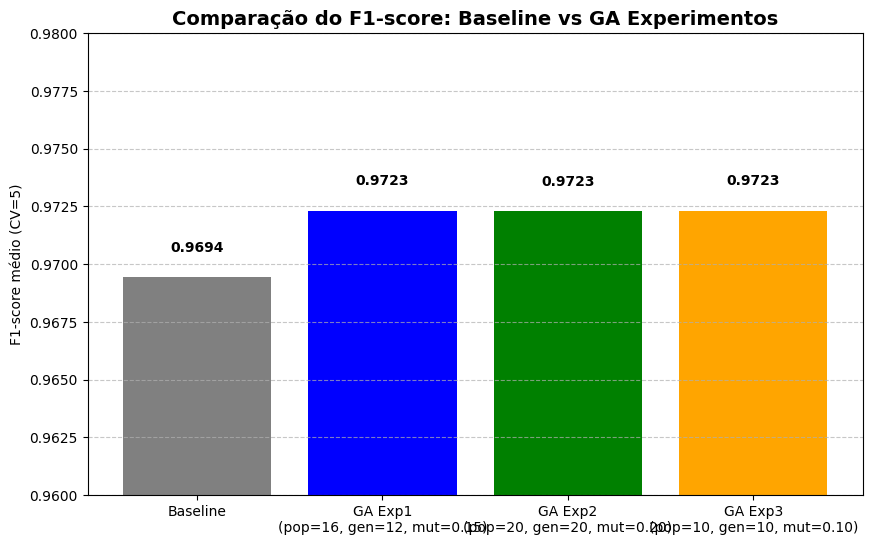

In [58]:
# Gráfico de barras
labels = [
    "Baseline",
    "GA Exp1\n(pop=16, gen=12, mut=0.15)",
    "GA Exp2\n(pop=20, gen=20, mut=0.20)",
    "GA Exp3\n(pop=10, gen=10, mut=0.10)"
]
scores = [baseline_result, exp1_result, exp2_result, exp3_result]

plt.figure(figsize=(10,6))
bars = plt.bar(labels, scores, color=["gray", "blue", "green", "orange"])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f"{score:.4f}", ha="center", va="bottom", fontsize=10, fontweight="bold")
plt.title("Comparação do F1-score: Baseline vs GA Experimentos", fontsize=14, fontweight="bold")
plt.ylabel("F1-score médio (CV=5)")
plt.ylim(0.96, 0.98)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

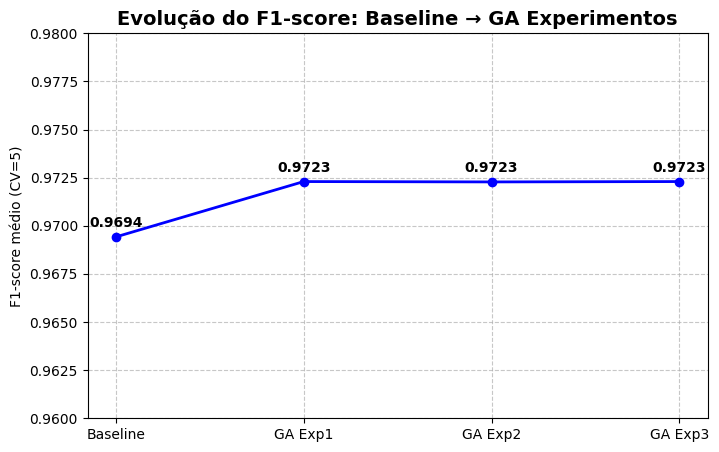

In [59]:
# Gráfico de linha
labels_simple = ["Baseline", "GA Exp1", "GA Exp2", "GA Exp3"]
scores_simple = [baseline_result, exp1_result, exp2_result, exp3_result]

plt.figure(figsize=(8,5))
plt.plot(labels_simple, scores_simple, marker="o", linestyle="-", color="blue", linewidth=2)
for i, score in enumerate(scores_simple):
    plt.text(i, score + 0.0005, f"{score:.4f}", ha="center", fontsize=10, fontweight="bold")
plt.title("Evolução do F1-score: Baseline → GA Experimentos", fontsize=14, fontweight="bold")
plt.ylabel("F1-score médio (CV=5)")
plt.ylim(0.96, 0.98)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [61]:
# Integração com LLM (OpenAI)
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def gerar_explicacao(hiperparams, baseline_f1, best_f1):
    prompt = f"""
    Você é um assistente médico de IA.  
    Um modelo de RandomForest foi otimizado via Algoritmo Genético.  
    - Hiperparâmetros escolhidos: {hiperparams}  
    - F1 baseline: {baseline_f1:.4f}  
    - F1 otimizado: {best_f1:.4f}  

    Explique em português, de forma clara e acessível para médicos,  
    os resultados obtidos.  

    Sua resposta deve conter duas partes:
    1. Explicação técnica resumida.
    2. **Interpretação na prática clínica**: destaque como essa melhoria no F1-score
       impacta diagnósticos, decisões médicas e segurança do paciente.

    Finalize a resposta com a linha "### Fim".
    """
    resposta = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=600,
        stop=["### Fim"]
    )
    return resposta.choices[0].message.content

try:
    explicacao = gerar_explicacao(best_solution, baseline_f1, best_f1)
    print("=== Explicação em linguagem natural ===\n")
    print(explicacao)
except Exception as e:
    print("⚠️ Não foi possível gerar a explicação com o LLM. Erro:", e)
    explicacao = None

=== Explicação em linguagem natural ===

### Explicação técnica resumida

O modelo de RandomForest, que é uma técnica de aprendizado de máquina utilizada para classificação, foi otimizado através de um Algoritmo Genético, que é uma abordagem inspirada na evolução natural para encontrar as melhores configurações (hiperparâmetros) do modelo. Os hiperparâmetros escolhidos foram [74, 13, 6], que podem estar ligados a configurações como o número de árvores, a profundidade máxima das árvores, entre outros aspectos que influenciam a performance do modelo.

Em termos de desempenho, o F1-score do modelo antes da otimização era de 0.9694, enquanto que após a otimização, o F1-score aumentou para 0.9723. O F1-score é uma medida que considera tanto a precisão quanto a sensibilidade do modelo, sendo particularmente útil em cenários onde as classes estão desbalanceadas. Esse aumento indica que o modelo se tornou mais eficaz na identificação de casos relevantes, mantendo um equilíbrio entre a identifi